In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
import matplotlib.pyplot as plt

/home/rajiv/miniconda3/envs/mlenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONFIGURATION
BATCH_SIZE = 128
TIME_STEPS = 1000
MID_STEPS = 200
BETA_START = 5e-6
BETA_END = 1e-2
LR_DDPM = 1e-4
LR_VAE = 1e-4

In [3]:
# Load dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

DDPM Model

In [4]:
# Define diffusion model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion_model = UNet2DModel(sample_size=28, in_channels=1, out_channels=1, layers_per_block=2, 
    block_out_channels=[32, 64],  # Only 2 blocks
    down_block_types=("DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D")).to(device)
scheduler = DDPMScheduler(num_train_timesteps=TIME_STEPS)
scheduler = DDPMScheduler(num_train_timesteps=TIME_STEPS, beta_start=BETA_START, beta_end=BETA_END, beta_schedule="scaled_linear")
optimizer = optim.Adam(diffusion_model.parameters(), lr=LR_DDPM)

print("Expected UNet input size:", diffusion_model.config.sample_size)

Expected UNet input size: 28


DDPM Forward Process

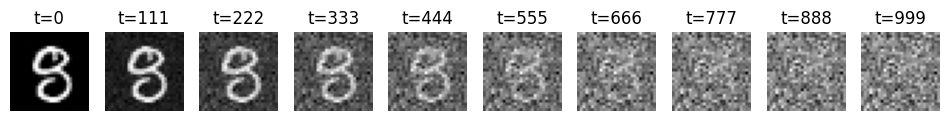

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_forward_process(dataloader, scheduler, device, num_intervals=4):
    x, _ = next(iter(dataloader))
    x = x.to(device)

    # Select a single image
    sample_idx = 0
    x_sample = x[sample_idx].unsqueeze(0)  # Shape: (1, 1, 28, 28)

    # Generate random noise
    noise = torch.randn_like(x_sample)
    timesteps = np.linspace(0, TIME_STEPS - 1, num_intervals, dtype=int)
    fig, axes = plt.subplots(1, len(timesteps), figsize=(12, 3))

    for i, t in enumerate(timesteps):
        timestep = torch.tensor([t], device=device)  # Single timestep
        noisy_x = scheduler.add_noise(x_sample, noise, timestep)  # Apply noise

        img = noisy_x.squeeze(0).squeeze(0).cpu().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"t={t}")
        axes[i].axis("off")

    plt.show()

show_forward_process(dataloader, scheduler, device, num_intervals=10)


In [208]:
print(device)

cuda


DDPM Training

In [ ]:
import torch
import os
from tqdm import tqdm

# Directory to save/load checkpoints
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Function to load checkpoint
def load_checkpoint(diffusion_model, optimizer, checkpoint_path, device):
    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        diffusion_model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1  # Resume from next epoch
        print(f"Checkpoint loaded: {checkpoint_path} | Resuming from Epoch {start_epoch}")
        return start_epoch
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch.")
        return 0  # Start from scratch if no checkpoint found

# Ask user for checkpoint path and epoch (Modify this if needed)
final_epoch = 5  # Default start from epoch 0
checkpoint_epoch = 0 #4 # Example: set this to a specific epoch to resume from

if checkpoint_epoch != 0:
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"diffusion_epoch_{checkpoint_epoch}.pth")
    resume_epoch = load_checkpoint(diffusion_model, optimizer, checkpoint_path, device)

# Train diffusion model directly on image space
for epoch in range(checkpoint_epoch, final_epoch):  # Resume from loaded epoch
    epoch_loss = 0  # Track epoch loss
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for i, (x, _) in enumerate(progress_bar):
        x = x.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, TIME_STEPS, (x.shape[0],), device=device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        pred_noise = diffusion_model(noisy_x, timesteps).sample
        loss = ((pred_noise - noise) ** 2).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update loss tracking
        epoch_loss += loss.item()

        # Update tqdm progress bar with loss
        progress_bar.set_postfix(loss=f"{loss.item():.6f}")

    # Print epoch loss
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch} | Avg Loss: {avg_loss:.6f}")

    # Save model checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"diffusion_epoch_{epoch}.pth")
    torch.save({
        "epoch": epoch,
        "model_state_dict": diffusion_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")


DDPM Samples

Generating Images: 1000it [00:05, 187.23it/s]


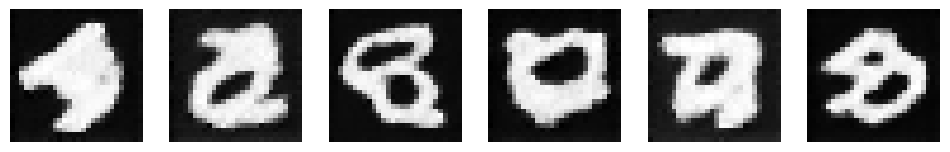

In [66]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def ddpm_inference(diffusion_model, scheduler, device, num_images=6, num_steps=TIME_STEPS):
    diffusion_model.eval()  # Set model to evaluation mode

    # Start with pure Gaussian noise
    img_shape = (num_images, 1, 28, 28)  # (batch, channels, height, width)
    samples = torch.randn(img_shape, device=device)

    # Generate images by reversing the diffusion process
    for t in tqdm(reversed(range(num_steps)), desc="Generating Images"):
        timestep = torch.tensor([t], device=device, dtype=torch.int64)  # Single timestep tensor

        with torch.no_grad():
            pred_noise = diffusion_model(samples, timestep).sample  # Predict noise

        # Denoise step
        samples = scheduler.step(model_output=pred_noise, timestep=timestep[0], sample=samples).prev_sample

    # Visualize generated samples
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        img = samples[i].squeeze(0).cpu().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].axis("off")

    plt.show()

# Call function to generate samples
ddpm_inference(diffusion_model, scheduler, device, num_images=6)


In [28]:
# # Train diffusion model
# for epoch in range(3):  # Small number of epochs for demonstration
#     for x, _ in dataloader:
#         print('xdim', x.shape)
#         x = x.to(device)
#         noise = torch.randn_like(x)
#         timesteps = torch.randint(0, 500, (x.shape[0],), device=device)
#         noisy_x = scheduler.add_noise(x, noise, timesteps)
#         print(noisy_x.shape, timesteps.dtype, noise.shape, noise.dtype)
#         pred_noise = diffusion_model(noisy_x, timesteps).sample
#         loss = ((pred_noise - noise) ** 2).mean()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

Creating Noisy Targets for VAE

In [89]:
# Get diffusion steps output in the middle of forward process (say 20% steps)
MID_STEPS=300
def get_noised_images(x, timesteps=MID_STEPS):
    noise = torch.randn_like(x)
    noised = scheduler.add_noise(x, noise, torch.full((x.shape[0],), timesteps, device=device))
    return torch.clamp(noised, 0, 1)  # Ensure pixel values are in range [0, 1]

# Prepare dataset for VAE
vae_inputs, vae_targets = [], []
for x, _ in dataloader:
    x = x.to(device)
    vae_inputs.append(x)
    vae_targets.append(get_noised_images(x))
vae_inputs, vae_targets = torch.cat(vae_inputs), torch.cat(vae_targets)

print(vae_inputs.shape, vae_targets.shape)  # Check shapes

torch.Size([59904, 1, 28, 28]) torch.Size([59904, 1, 28, 28])


In [76]:
#Eventually 

# MID_STEPS = 200

# def get_noised_images(x, timesteps=MID_STEPS):
#     noise = torch.randn_like(x)
#     noised = scheduler.add_noise(x, noise, torch.full((x.shape[0],), timesteps, device=x.device))
#     return torch.clamp(noised, -1, 1)  # Ensure values stay in range

# # Prepare dataset for VAE
# vae_inputs, vae_targets = [], []
# for x, _ in dataloader:
#     x = x.to(device)
    
#     # Shift from [0,1] to [-1,1]
#     x_shifted = 2 * x - 1
    
#     # Add clamped noise
#     x_noised = get_noised_images(x_shifted)
    
#     # Shift back to [0,1]
#     x_noised = (x_noised + 1) / 2

#     vae_inputs.append(x)
#     vae_targets.append(x_noised)

# vae_inputs, vae_targets = torch.cat(vae_inputs), torch.cat(vae_targets)

# print(vae_inputs.shape, vae_targets.shape)  # Check shapes


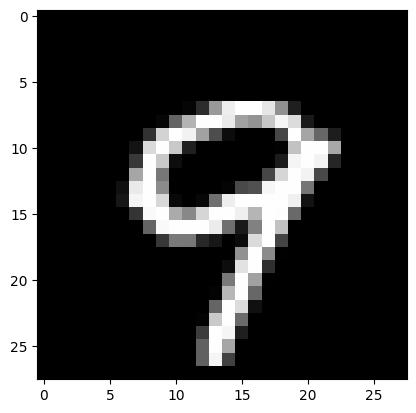

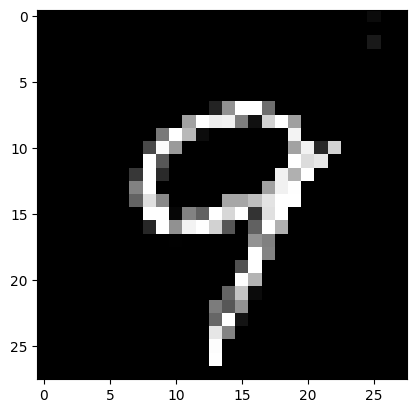

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [90]:
def show_img(inp):
    img = inp.squeeze(0).cpu().numpy() 
    plt.imshow(img, cmap="gray")
    plt.show()

show_img(vae_inputs[1])
show_img(vae_targets[1])
print(vae_inputs[1], vae_targets[1])  # Check shapes

Training VAE

In [78]:
# # Define simple Autoencoder
# class VAE(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 128), nn.ReLU(), nn.Linear(128, 32))
#         self.decoder = nn.Sequential(nn.Linear(32, 128), nn.ReLU(), nn.Linear(128, 28*28), nn.Unflatten(1, (1, 28, 28)))
    
#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

# # Train VAE
# def train_vae(vae, inputs, targets, epochs):
#     vae_optimizer = optim.Adam(vae.parameters(), lr=LR_VAE)
#     loss_fn = nn.MSELoss()

#     for epoch in range(epochs):
#         print('epoch', epoch)
#         for i in range(0, len(vae_inputs), BATCH_SIZE):
#             x_batch = vae_inputs[i:i+BATCH_SIZE].to(device)
#             target_batch = vae_targets[i:i+BATCH_SIZE].to(device)
#             output = vae(x_batch)
#             loss = loss_fn(output, target_batch)
#             vae_optimizer.zero_grad()
#             loss.backward()
#             vae_optimizer.step()



Retry 0

In [79]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm  # Import tqdm for progress bar

# # Define Convolutional VAE
# class VAE(nn.Module):
#     def __init__(self, latent_dim=32):
#         super(VAE, self).__init__()
        
#         # Encoder: Conv layers + MLP for mean & logvar
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
#             nn.Conv2d(32, 64, kernel_size=7)  # 7x7 -> 1x1
#         )
#         self.fc_mu = nn.Conv2d(64, latent_dim, kernel_size=1)
#         self.fc_logvar = nn.Conv2d(64, latent_dim, kernel_size=1)
        
#         # Decoder: Upsample from latent space
#         self.fc_z = nn.ConvTranspose2d(latent_dim, 64, kernel_size=1)
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, kernel_size=7),  # 1x1 -> 7x7
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
#             nn.Sigmoid()  # Output in [0,1]
#         )

#     def reparameterize(self, mu, logvar):
#         """Reparameterization trick to sample latent variable"""
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def encode(self, x):
#         x = self.encoder(x)
#         mu = self.fc_mu(x).squeeze()
#         logvar = self.fc_logvar(x).squeeze()
#         return mu, logvar

#     def decode(self, z):
#         z = z.unsqueeze(-1).unsqueeze(-1)  # Reshape for conv layers
#         x = self.fc_z(z)
#         x = self.decoder(x)
#         return x

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar


# # Training function using your tqdm setup
# def train_vae(vae, vae_inputs, vae_targets, epochs):
#     vae.to(device)  # Use global device
#     vae_optimizer = optim.Adam(vae.parameters(), lr=LR_VAE)  # Use global LR_VAE
#     loss_fn = nn.MSELoss()

#     for epoch in range(epochs):
#         epoch_loss = 0.0
#         progress_bar = tqdm(range(0, len(vae_inputs), BATCH_SIZE), desc=f"Epoch {epoch+1}")

#         for i in progress_bar:
#             x_batch = vae_inputs[i:i+BATCH_SIZE].to(device)
#             target_batch = vae_targets[i:i+BATCH_SIZE].to(device)

#             output, mu, logvar = vae(x_batch)
#             assert output.shape == target_batch.shape, f"Output shape {output.shape} does not match target {target_batch.shape}"

#             # VAE Loss: Reconstruction + KL Divergence
#             recon_loss = loss_fn(output, target_batch)
#             kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / BATCH_SIZE
#             loss = recon_loss + 5 * kld_loss  # KL weight

#             vae_optimizer.zero_grad()
#             loss.backward()
#             vae_optimizer.step()

#             # Update progress bar with loss
#             epoch_loss += loss.item()
#             progress_bar.set_postfix(loss=loss.item())

#         print(f"Epoch {epoch+1} Loss: {epoch_loss / len(vae_inputs):.6f}")


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        self.fc1 = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.fc2 = nn.Conv2d(64, latent_dim, kernel_size=1)
        self.fc3 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc1(x).squeeze()
        logvar = self.fc2(x).squeeze()
        return mu, logvar

    def decode(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)
        # print('z', z.shape)
        x = self.fc3(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    recon_x = torch.clamp(recon_x, 0, 1  )  # Ensure values are within [0,1]
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return KLD
    return BCE + KLD

from torch.utils.data import DataLoader, TensorDataset

def train_vae(model, vae_inputs, vae_targets, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    dataset = TensorDataset(vae_inputs, vae_targets)  # Wrap tensors in dataset
    data_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    for epoch in range(config['num_epochs']):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(data_loader):  # Unpack inputs & targets
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            # print('RECON', recon_batch[0])
            # print( 'TARGET', target[0])
            loss = loss_function(recon_batch, target, mu, logvar)  # Use target in loss
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset)}')

    # Save the trained model
    torch.save(model.state_dict(), config['save_path'])

In [92]:

vae = VAE().to(device)
LR_VAE = 4e-4
BATCH_SIZE=64
config = {
    'lr': LR_VAE,               # Learning rate for Adam optimizer
    'batch_size': BATCH_SIZE,         # Batch size for training
    'num_epochs': 10,         # Number of training epochs
    'save_path': 'checkpoints/vae.pth'    # Path to save trained model
}
train_vae(vae, vae_inputs, vae_targets, config)


Epoch 1, Loss: 183.37763548304892
Epoch 2, Loss: 134.66398879809256
Epoch 3, Loss: 121.18305908105312
Epoch 4, Loss: 115.86826070149739
Epoch 5, Loss: 113.21805270920451
Epoch 6, Loss: 111.6469916726789
Epoch 7, Loss: 110.72747183253622
Epoch 8, Loss: 110.10733913356422
Epoch 9, Loss: 109.60810821076744
Epoch 10, Loss: 109.20344459501086


Retry1

In [82]:
with torch.no_grad():
    latent_samples = torch.randn(16, 32, device=device)  # Sample from latent space

    # latent_samples[0] = vae.encoder(vae_inputs[1]).flatten()
    # latent_samples[1] = vae.encoder(vae_inputs[2]).flatten()
    # latent_samples[2] = 0.5 * latent_samples[0] + 0.5*latent_samples[1]

In [83]:
# Sampling
with torch.no_grad():
    print(latent_samples.shape)  # Check output shape
    vae_output = vae.decode(latent_samples)

    sampled = vae_output  # Start from D(x), which is the noisy image at t=100
    timesteps = list(range(MID_STEPS, -1, -1))  # Reverse diffusion from t=100 to t=0
    for t in timesteps:
        timestep = torch.full((sampled.shape[0],), t, device=device)
        noise_pred = diffusion_model(sampled, timestep).sample  # Predict noise
        sampled = scheduler.step(noise_pred, t, sampled).prev_sample  # Reverse diffusion step

torch.Size([16, 32])


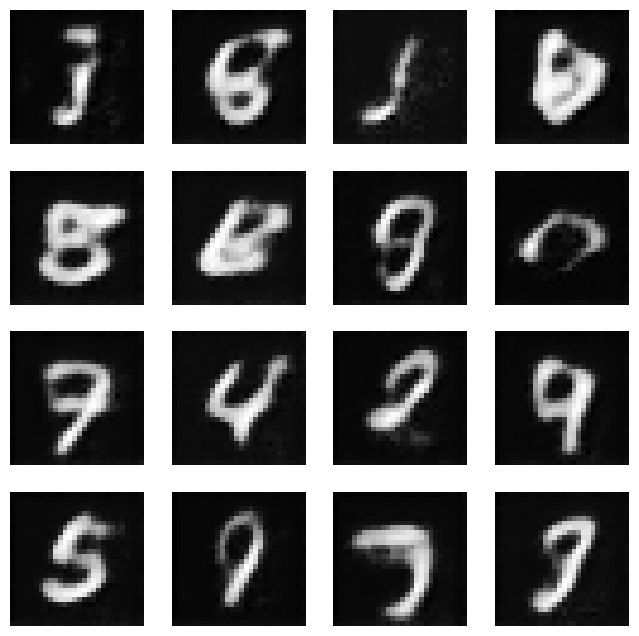

In [84]:
# samples = vae_xx_output_diffused.cpu().numpy().squeeze()  # Shape: (16, 28, 28)
samples = sampled.cpu().numpy().squeeze()  # Shape: (16, 28, 28)

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i], cmap="gray")
    ax.axis("off")  # Hide axis

plt.show()

Experiment

latent_dim 32


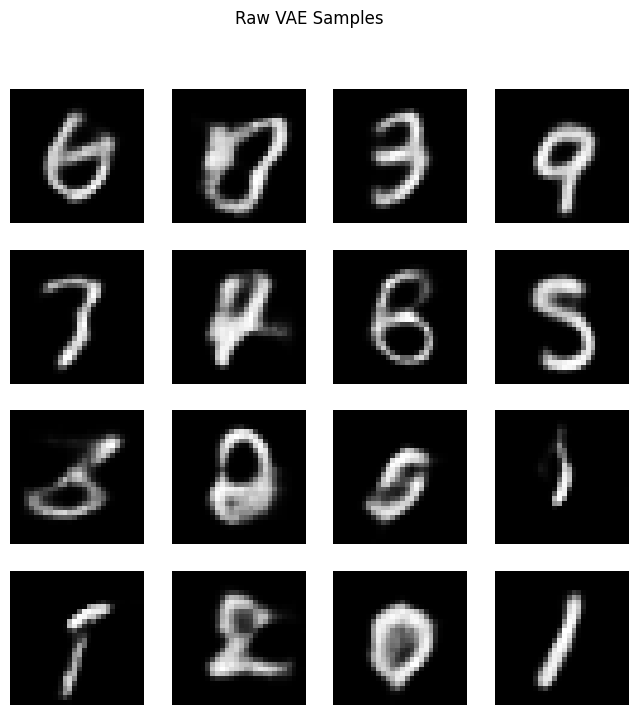

latent_dim 32


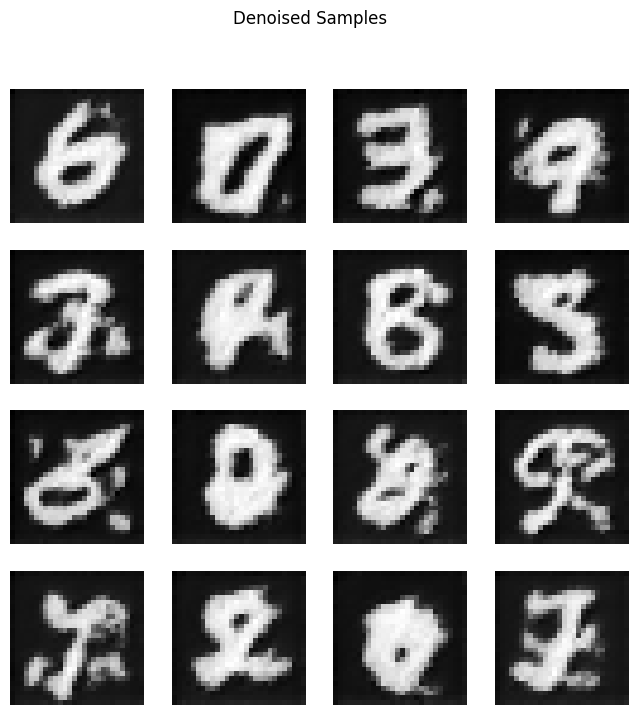

In [95]:
import torch
import matplotlib.pyplot as plt

def generate_samples(vae, apply_denoising=False, num_samples=16, vae_output=None):
    vae.eval()
    latent_dim = 32  # Assuming last encoder layer is linear
    print("latent_dim", latent_dim)
    device = next(vae.parameters()).device

    with torch.no_grad():
        if vae_output is None:
            latent_samples = torch.randn(num_samples, latent_dim, device=device)  # Sample latent space
            vae_output = vae.decode(latent_samples)  # Decode to images

        if apply_denoising:
            sampled = vae_output  # Start from VAE output
            timesteps = list(range(MID_STEPS, -1, -1))  # Reverse diffusion from t=T to t=0

            for t in timesteps:
                timestep = torch.full((sampled.shape[0],), t, device=device)
                noise_pred = diffusion_model(sampled, timestep).sample  # Predict noise
                sampled = scheduler.step(noise_pred, t, sampled).prev_sample  # Reverse diffusion step
        else:
            sampled = vae_output  # Use raw VAE output

    return sampled.cpu()  # Return generated images


def plot_samples(samples, title="Generated Samples"):
    samples = samples.numpy().squeeze()  # Convert to NumPy if tensor

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap="gray")
        ax.axis("off")  # Hide axis
    
    plt.suptitle(title)
    plt.show()

samples = generate_samples(vae, apply_denoising=False)  # Generate raw VAE output
plot_samples(samples, title="Raw VAE Samples")

samples_denoised = generate_samples(vae, apply_denoising=True, vae_output =samples.to(device))  # Generate with diffusion
plot_samples(samples_denoised, title="Denoised Samples")  # Pass raw VAE output for denoising

In [86]:
# Blurring experiment

#### STANDARD VAE